In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_models import make_model
import porepy as pp


model = make_model(
    {
        "geometry": 1,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore




Sim time: 0, Dt: 0.5
sticking: 4, sliding: 0, open: 0


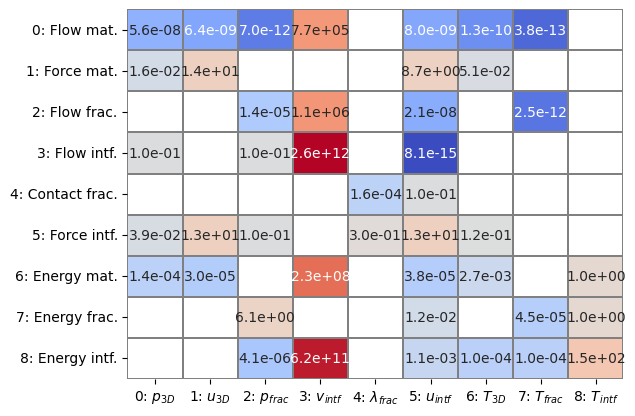

In [2]:
data = load_data(f"../../stats/{model.simulation_name()}.json")
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    data, 3, "../../matrices"
)
model.linear_system = mat, rhs
model.bmat.mat = mat
model.bmat.plot_max()
J = model.bmat

In [3]:
data[1].linear_solves

[LinearSolveStats(simulation_dt=0.5, krylov_iters=8, petsc_converged_reason=2, error_matrix_contribution=0.023038140634002457, num_sticking=4, num_sliding=0, num_open=0, coulomb_mismatch=0, sticking_u_mismatch=0.0, lambdan_max=0.0005011977924215108, lambdat_max=0.00012537144236755317, un_max=0.00010038328100375345, ut_max=5.421010862427522e-20, matrix_id='stats_thermal_geo1x1_sol2_bb2_fr1_1730234373657.npz', rhs_id='stats_thermal_geo1x1_sol2_bb2_fr1_1730234373657_rhs.npy', state_id='stats_thermal_geo1x1_sol2_bb2_fr1_1730234373657_state.npy', iterate_id='stats_thermal_geo1x1_sol2_bb2_fr1_1730234373657_iterate.npy'),
 LinearSolveStats(simulation_dt=0.5, krylov_iters=9, petsc_converged_reason=2, error_matrix_contribution=0.023038140634002457, num_sticking=3, num_sliding=1, num_open=0, coulomb_mismatch=4.438275533968282e-05, sticking_u_mismatch=0.0, lambdan_max=0.0004644283659031546, lambdat_max=0.00012496104061039397, un_max=0.00010055850462441273, ut_max=5.421010862427522e-20, matrix_id=

In [8]:
tmp = model.bmat
# tmp.plot_max()

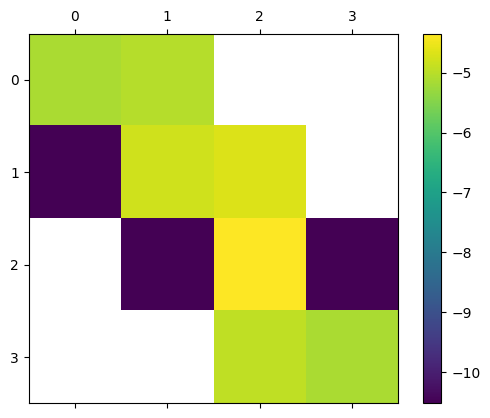

In [5]:
tmp[[7]].matshow(log=True)

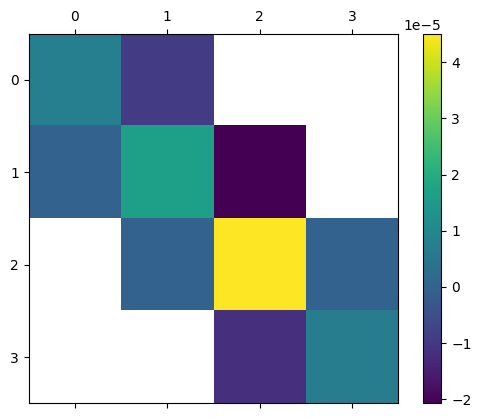

In [6]:
tmp[[7]].matshow(log=False)

In [7]:
tmp[[7]].mat.toarray()[9]

IndexError: index 9 is out of bounds for axis 0 with size 4

Solve  took: 0.0
True residual permuted: 1.9717017752844433e-15
PETSc Converged Reason: 2


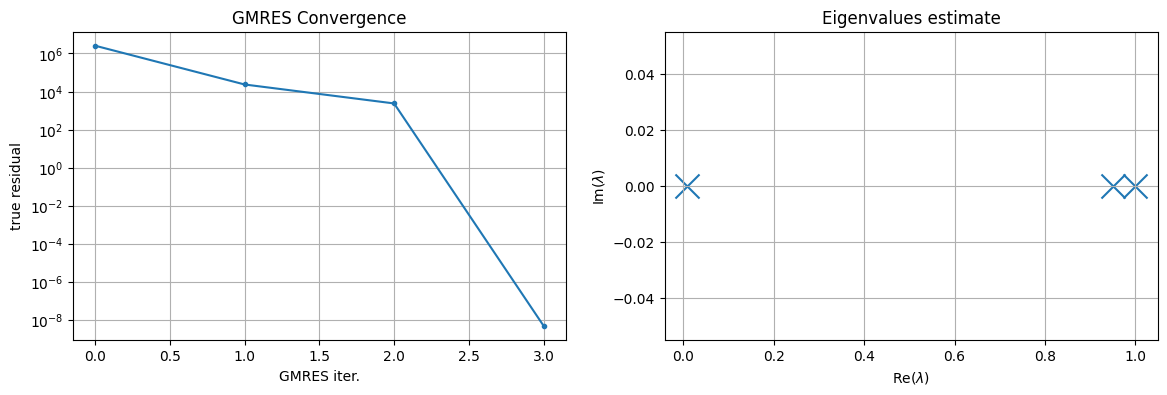

In [43]:
from block_matrix import MultiStageScheme
from mat_utils import RestrictedOperator, PetscILU, PetscAMGFlow

tmp = model.bmat[[7]]
_ = solve_petsc_new(
    tmp,
    prec=PetscAMGFlow(tmp.mat),
    rhs_global=rhs,
)

Solve  took: 0.0
True residual permuted: 1.0
PETSc Converged Reason: -9


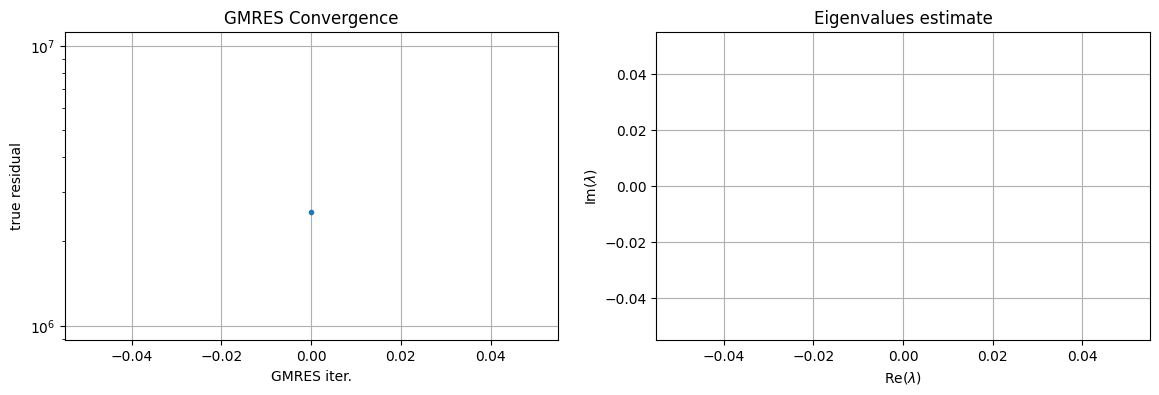

In [37]:
from block_matrix import MultiStageScheme
from mat_utils import RestrictedOperator, PetscILU, PetscAMGFlow

tmp = model.bmat[[0, 2, 6, 7]]
_ = solve_petsc_new(
    tmp,
    solve_schema=MultiStageScheme(
        groups=[0,2,6,7],
        stages=[
            lambda bmat: RestrictedOperator(
                bmat, to_groups=[0, 2], prec=lambda bmat: PetscAMGFlow(bmat.mat)
            ),
            lambda bmat: PetscILU(bmat.mat),
        ],
    ),
    rhs_global=rhs,
)

Solve  took: 0.01
True residual permuted: 7.69647238054134e-11
True residual: 7.696245059854385e-11
PETSc Converged Reason: 2


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


{'mat_Q': BlockMatrixStorage of shape (1032, 1032) with 44778 elements with 9x9 active groups,
 'rhs_Q': array([-1.80972629e-09, -0.00000000e+00, -4.78627368e-06, ...,
         1.36286377e-05, -3.01234335e-05,  3.73632244e-06]),
 'prec': <mat_utils.FieldSplit at 0x7cf8c92e7050>}

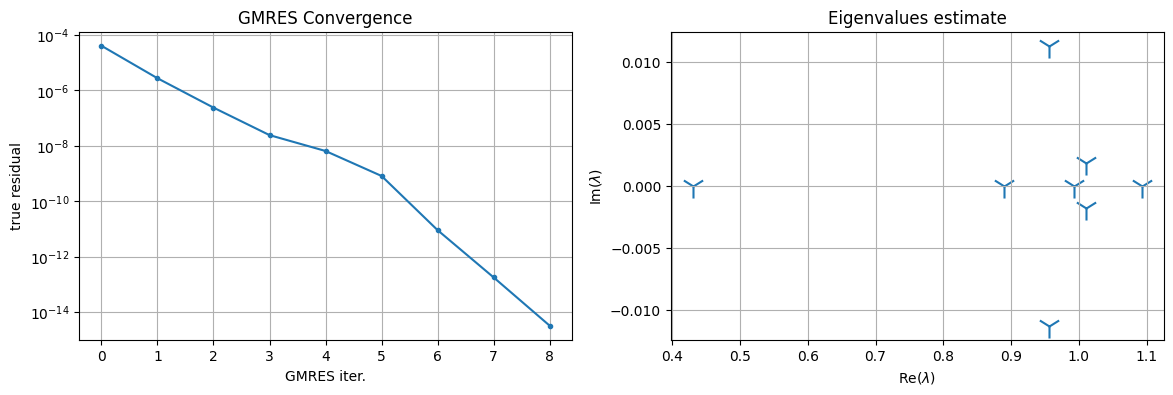

In [42]:
from block_matrix import FieldSplitScheme
from fixed_stress import make_fs_analytical
from mat_utils import (
    extract_diag_inv,
    inv_block_diag,
    PetscAMGFlow,
    PetscAMGFlow,
    PetscAMGMechanics,
    PetscILU,
)
from pp_utils import build_mechanics_near_null_space

solve_petsc_new(
    J[[0, 1, 2, 3, 4, 5, 6, 7, 8]],
    solve_schema=FieldSplitScheme(
        # Exactly eliminate contact mechanics (assuming linearly-transformed system)
        groups=[4],
        solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
        complement=FieldSplitScheme(
            # Eliminate interface flow, it is not coupled with (1, 4, 5)
            # Use diag() to approximate inverse and ILU to solve linear systems
            groups=[3],
            solve=lambda bmat: PetscILU(bmat[[3]].mat),
            invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
            complement=FieldSplitScheme(
                # Eliminate interface temperature
                # Use diag() to approximate inverse and ILU to solve linear systems
                groups=[8],
                solve=lambda bmat: PetscILU(bmat[[8]].mat),
                invertor=lambda bmat: extract_diag_inv(bmat[[8]].mat),
                complement=FieldSplitScheme(
                    # Eliminate elasticity. Use AMG to solve linear systems and fixed
                    # stress to approximate inverse.
                    groups=[1, 5],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[1, 5]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model),
                    ),
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, blocks=[0, 2, 6, 7]
                    ).mat,
                    complement=MultiStageScheme(
                        # CPR for P-T coupling
                        groups=[0, 2, 6, 7],
                        stages=[
                            lambda bmat: RestrictedOperator(
                                bmat,
                                to_groups=[0, 2],
                                prec=lambda bmat: PetscAMGFlow(bmat.mat),
                            ),
                            lambda bmat: PetscILU(bmat.mat),
                        ],
                    ),
                ),
            ),
        ),
    ),
    pc_side="right",
    rhs_global=rhs,
    Qright=model.Qright(),
)

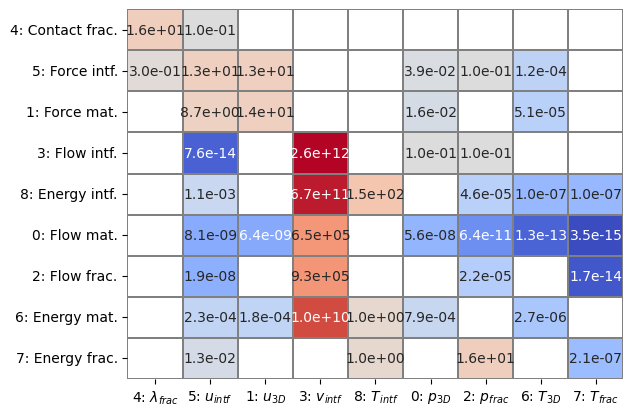

In [6]:
J[[4, 5, 1, 3, 8, 0, 2, 6, 7]].plot_max()